# Соревнование по Регрессии. 2 Семестр

## Ссылка на соревнование

https://www.kaggle.com/competitions/urfuaieng2022reg2

## Целевая метрика

**mse < 100**

## Dataset Description

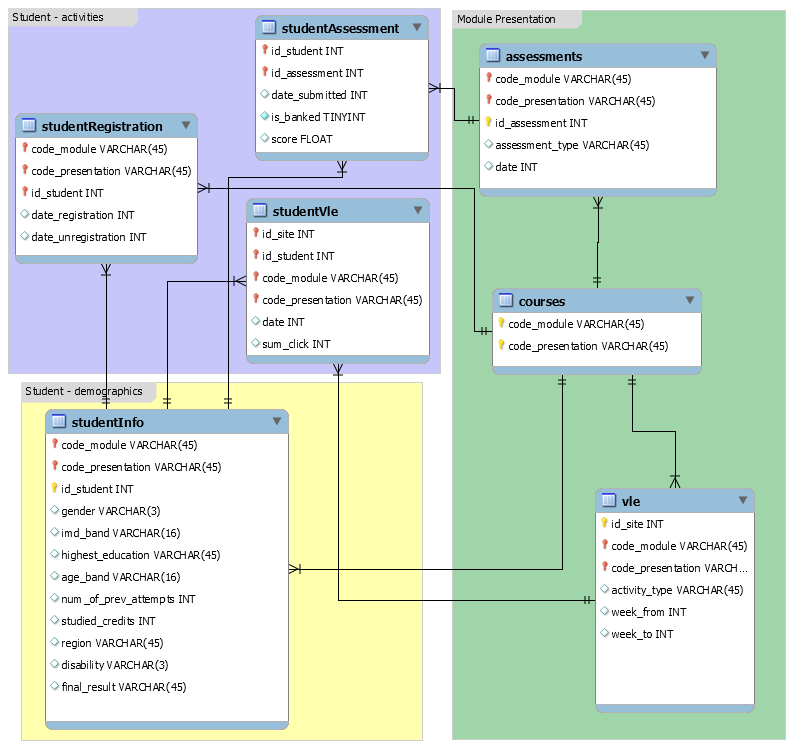

In [1]:
from IPython.display import Image
Image("./Data/k4_model.png", width=620, height=480) 

**Файлы**  
*Которые оригинальные (с небольшими удалениями)*
- assessments.csv - Файл содержит информацию об оценках в модулях-презентациях. Обычно каждая презентация имеет ряд оценок, за которыми следует итоговый экзамен.

- courses.csv - Файл содержит список всех доступных модулей и их презентаций.

- studentInfo.csv - Файл содержит демографическую информацию об учащихся.

- studentAssessment.csv - Файл содержит результаты оценок студентов. Если учащийся не сдает оценку, результат не записывается. Итоговые экзаменационные материалы отсутствуют, если результат оценивания не хранится в системе.

- studentRegistration.csv - Файл содержит информацию о времени регистрации студента на презентацию модуля.

- studentVle.csv - Фйал содержит информацию о взаимодействии каждого учащегося с материалами в VLE.

- vle.csv - Файл содержит информацию о доступных материалах в VLE (Virtual Learning Environment). Обычно это html-страницы, pdf-файлы и т. д.  

Студенты имеют доступ к этим материалам в Интернете, и их взаимодействие с материалами записывается.

**Которые описывают тренировочную и тестовую выборку**
- Test_Who.csv - перечень id_student, code_modelu и code_presentation для тестовой выборки. ID - внутренний идентификатор для оценки на Kaggle

- Train_Who.csv - перечень id_student, code_modelu и code_presentation для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle

- Train_Target_reg.csv - целевая метрика для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle, как в файле Train_Who.csv

- Submission_reg.csv - Пример файла для загрузки, в который проставлены все средние значения(кто знает может использовать для подгонки 👀). ID - внутренний идентификатор для оценки на Kaggle, как в файле Test_Who.csv

### Загрузка библиотек

In [2]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import mean_squared_error as mse

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

Изучим и предобработаем таблицы с данными

- assessments

In [6]:
assessments = pd.read_csv('assessments.csv')
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


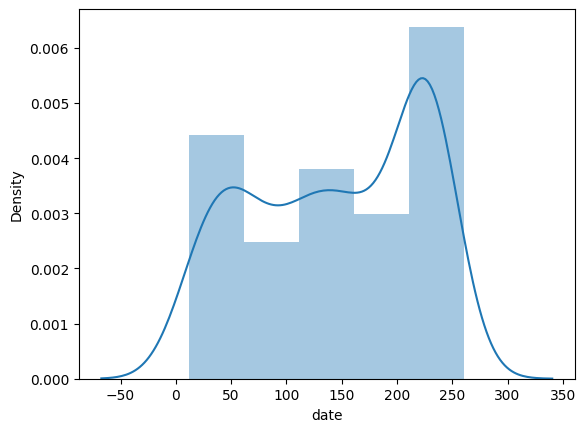

In [7]:
sns_plot = sns.distplot(assessments['date'])
fig = sns_plot.get_figure()

In [8]:
a = assessments.groupby(['code_module','code_presentation','assessment_type'])['weight'].count().reset_index()
a.head()

,code_module,code_presentation,assessment_type,weight
0,AAA,2013J,Exam,1
1,AAA,2013J,TMA,5
2,AAA,2014J,Exam,1
3,AAA,2014J,TMA,5
4,BBB,2013B,CMA,5


In [9]:
a_pivot = a.pivot(index=["code_module", "code_presentation"]\
                        , columns=["assessment_type"], values="weight").reset_index()
a_pivot.columns = ['code_module', 'code_presentation', 'CMA_count', 'Exam_count', 'TMA_count']
a_pivot.head(2)

,code_module,code_presentation,CMA_count,Exam_count,TMA_count
0,AAA,2013J,NaN,1.0,5.0
1,AAA,2014J,NaN,1.0,5.0


In [10]:
agg_ass_weight = assessments.groupby(['code_module','code_presentation'])\
.agg(median_weight_pres = ('weight',np.median), mean_weight_pres = ('weight',np.mean),\
     total_weight_pres = ('weight',sum)).reset_index()
agg_ass_weight.head(2)

,code_module,code_presentation,median_weight_pres,mean_weight_pres,total_weight_pres
0,AAA,2013J,20.0,33.333333,200.0
1,AAA,2014J,20.0,33.333333,200.0


In [11]:
agg_ass_date = assessments.groupby(['code_module','code_presentation'])\
.agg(median_date_pres = ('date',np.median), mean_date_pres = ('date',np.mean),\
     total_date_pres = ('date',sum)).reset_index()
agg_ass_date.head(2)

,code_module,code_presentation,median_date_pres,mean_date_pres,total_date_pres
0,AAA,2013J,117.0,114.2,571.0
1,AAA,2014J,117.0,114.2,571.0


In [12]:
agg_ass_datecount = assessments.groupby(['code_module','code_presentation'])['id_assessment'].count()
agg_ass_datecount.head()                                    

code_module  code_presentation
AAA          2013J                 6
             2014J                 6
BBB          2013B                12
             2013J                12
             2014B                12
Name: id_assessment, dtype: int64

In [13]:
agg_ass_all = pd.merge(
    agg_ass_weight,
    agg_ass_date,
    how="left",
    on=(['code_module','code_presentation'])
)
agg_ass_all

,code_module,code_presentation,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres
0,AAA,2013J,20.00,33.333333,200.0,117.0,114.200000,571.0
1,AAA,2014J,20.00,33.333333,200.0,117.0,114.200000,571.0
2,BBB,2013B,11.50,16.666667,200.0,124.0,112.545455,1238.0
3,BBB,2013J,11.50,16.666667,200.0,131.0,120.181818,1322.0
4,BBB,2014B,11.50,16.666667,200.0,117.0,108.090909,1189.0
5,BBB,2014J,27.50,33.333333,200.0,110.0,107.200000,536.0
6,CCC,2014B,15.50,30.000000,300.0,119.5,114.250000,914.0
7,CCC,2014J,15.50,30.000000,300.0,126.5,118.625000,949.0
8,DDD,2013B,6.75,14.285714,200.0,115.0,118.428571,1658.0
9,DDD,2013J,20.00,28.571429,200.0,123.0,131.714286,922.0


In [14]:
agg_ass_all2 = pd.merge(
    agg_ass_all,
    agg_ass_datecount,
    how="left",
    on=(['code_module','code_presentation']))
agg_ass_all2 = agg_ass_all2.rename(columns = {'id_assessment':'id_assessment_count'})
agg_ass_all2.head(2)

,code_module,code_presentation,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count
0,AAA,2013J,20.0,33.333333,200.0,117.0,114.2,571.0,6
1,AAA,2014J,20.0,33.333333,200.0,117.0,114.2,571.0,6


In [15]:
agg_ass_all2.shape

(22, 9)

In [16]:
assessments[(assessments['code_module'] == 'AAA') & (assessments['code_presentation'] == '2013J')]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
5,AAA,2013J,1757,Exam,NaN,100.0


In [17]:
assessments[assessments['assessment_type'] == 'Exam']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [18]:
assessments[assessments['assessment_type'] == 'CMA']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
12,BBB,2013B,14991,CMA,54.0,1.0
13,BBB,2013B,14992,CMA,89.0,1.0
14,BBB,2013B,14993,CMA,124.0,1.0
15,BBB,2013B,14994,CMA,159.0,1.0
16,BBB,2013B,14995,CMA,187.0,1.0
...,...,...,...,...,...,...
197,GGG,2014J,37439,CMA,229.0,0.0
198,GGG,2014J,37440,CMA,229.0,0.0
199,GGG,2014J,37441,CMA,229.0,0.0
200,GGG,2014J,37442,CMA,229.0,0.0


- studentAssessment

In [19]:
studentAssessment = pd.read_csv('studentAssessment.csv')
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0
2,1752,31604,17,0
3,1752,32885,26,0
4,1752,38053,19,0


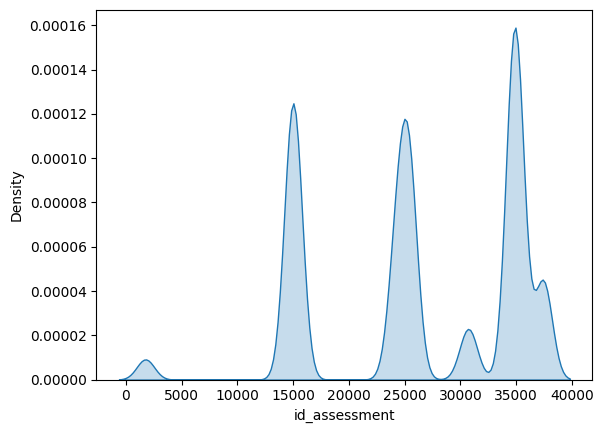

In [20]:
snsplot = sns.kdeplot(studentAssessment['id_assessment'], shade=True)
fig = snsplot.get_figure()

In [21]:
st_ass_count = studentAssessment.groupby(['id_student'])['is_banked'].count()
st_ass_count.head(2)  

id_student
6516    5
8462    7
Name: is_banked, dtype: int64

In [22]:
st_ass_sum = studentAssessment.groupby(['id_student']).agg(is_banked_sum = ('is_banked',sum)).reset_index()
st_ass_sum.head(2)  

,id_student,is_banked_sum
0,6516,0
1,8462,4


In [23]:
st_ass_all = pd.merge(
    st_ass_sum,
    st_ass_count,
    how="left",
    on=(['id_student']))
st_ass_all.head(2)

,id_student,is_banked_sum,is_banked
0,6516,0,5
1,8462,4,7


In [24]:
assessment_united = pd.merge(
    studentAssessment,
    assessments,
    how="left",
    on=(['id_assessment']))
assessment_united.head(2)

,id_assessment,id_student,date_submitted,is_banked,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,AAA,2013J,TMA,19.0,10.0


In [25]:
st_weight = assessment_united.groupby(['code_module','code_presentation','id_student'])\
.agg(total_stud_weight = ('weight',sum)).reset_index()
st_weight

,code_module,code_presentation,id_student,total_stud_weight
0,AAA,2013J,11391,100.0
1,AAA,2013J,28400,100.0
2,AAA,2013J,31604,100.0
3,AAA,2013J,32885,100.0
4,AAA,2013J,38053,100.0
...,...,...,...,...
25838,GGG,2014J,2620947,0.0
25839,GGG,2014J,2645731,0.0
25840,GGG,2014J,2648187,0.0
25841,GGG,2014J,2679821,0.0


In [26]:
assessment_united['diff_date'] = assessment_united['date'] - assessment_united['date_submitted']
assessment_united.head(2)

,id_assessment,id_student,date_submitted,is_banked,code_module,code_presentation,assessment_type,date,weight,diff_date
0,1752,11391,18,0,AAA,2013J,TMA,19.0,10.0,1.0
1,1752,28400,22,0,AAA,2013J,TMA,19.0,10.0,-3.0


In [27]:
diff_dates = assessment_united.groupby(['code_module','code_presentation','id_student'])\
.agg(median_diff_date = ('diff_date',np.median), mean_diff_date = ('diff_date',np.mean),\
sum_diff_date = ('diff_date',sum)).reset_index()
diff_dates

,code_module,code_presentation,id_student,median_diff_date,mean_diff_date,sum_diff_date
0,AAA,2013J,11391,2.0,1.800000,9.0
1,AAA,2013J,28400,2.0,0.000000,0.0
2,AAA,2013J,31604,2.0,2.000000,10.0
3,AAA,2013J,32885,-7.0,-11.400000,-57.0
4,AAA,2013J,38053,0.0,-2.000000,-10.0
...,...,...,...,...,...,...
25838,GGG,2014J,2620947,9.0,31.444444,283.0
25839,GGG,2014J,2645731,29.0,36.222222,326.0
25840,GGG,2014J,2648187,22.0,45.333333,408.0
25841,GGG,2014J,2679821,79.5,79.500000,159.0


- Train_Who

In [28]:
Train_Who =  pd.read_csv('Train_Who.csv')
Train_Who.head()

,ID,id_student,code_module,code_presentation
0,0,464685,DDD,2014B
1,1,606593,DDD,2013J
2,2,1674799,CCC,2014J
3,3,195246,FFF,2014J
4,4,582080,FFF,2013J


- studentInfo

In [29]:
studentInfo = pd.read_csv('studentInfo.csv')
studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


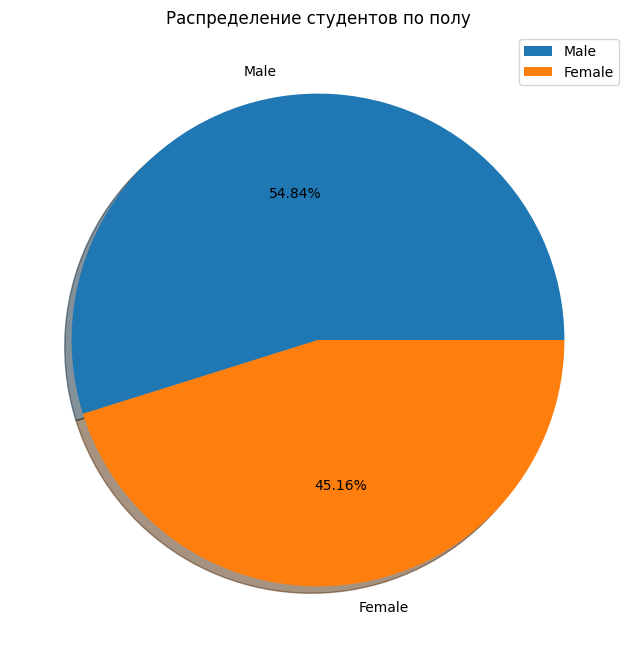

In [30]:
sizes = [studentInfo.gender[studentInfo['gender']=='M'].count(), studentInfo.gender[studentInfo['gender']=='F'].count()]
labels = ['Male', 'Female']
figure, axes = plt.subplots(figsize=(10, 8))
axes.pie(sizes, labels=labels,shadow=True,autopct = '%1.2f%%')
plt.legend()
plt.title("Распределение студентов по полу", size = 12)
plt.show()

**Уберем пустые значение и исправим опечатку в '10-20' (да, глаз режет, я максималист)**

In [31]:
studentInfo = studentInfo.fillna('0%')

In [32]:
studentInfo.imd_band = np.where(studentInfo.imd_band =='10-20', '10-20%', studentInfo.imd_band)

- studentRegistration

In [33]:
studentRegistration = pd.read_csv('studentRegistration.csv')
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0
2,AAA,2013J,30268,-92.0
3,AAA,2013J,31604,-52.0
4,AAA,2013J,32885,-176.0


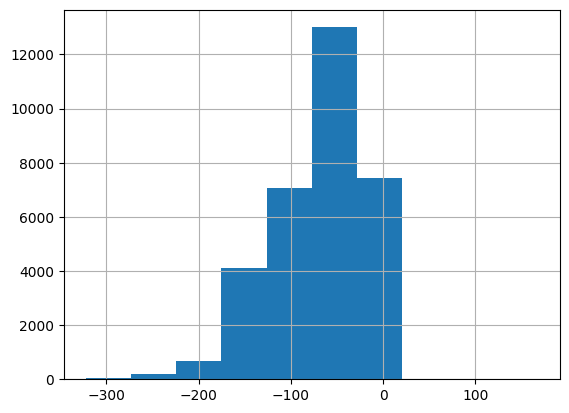

In [34]:
h = studentRegistration['date_registration'].hist()
fig = h.get_figure()

- studentVle

In [35]:
studentVle = pd.read_csv('studentVle.csv')
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


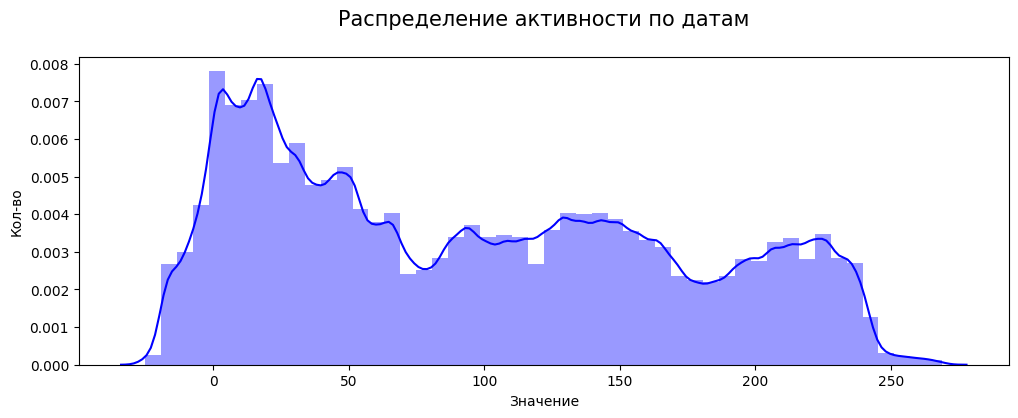

In [36]:
plt.figure(figsize=(12,4))
sns.distplot(studentVle['date'].values, bins=50, color='blue')
plt.title('Распределение активности по датам\n',fontsize=15)
plt.xlabel('Значение'); plt.ylabel('Кол-во');

In [37]:
studentVle2=studentVle\
.groupby(['code_module','code_presentation', 'id_student'])\
.agg(median_date = ('date',np.mean), mean_date = ('date',np.mean), sum_date = ('date',sum),\
     median_click = ('sum_click',np.mean), mean_click = ('sum_click',np.mean), sum_click_by_site = ('sum_click',sum))
studentVle2.reset_index(inplace = True)

In [38]:
studentVle2

,code_module,code_presentation,id_student,median_date,mean_date,sum_date,median_click,mean_click,sum_click_by_site
0,AAA,2013J,11391,102.132653,102.132653,20018,4.765306,4.765306,934
1,AAA,2013J,28400,86.993023,86.993023,37407,3.337209,3.337209,1435
2,AAA,2013J,30268,2.355263,2.355263,179,3.697368,3.697368,281
3,AAA,2013J,31604,106.147813,106.147813,70376,3.254902,3.254902,2158
4,AAA,2013J,32885,91.934659,91.934659,32361,2.937500,2.937500,1034
...,...,...,...,...,...,...,...,...,...
29223,GGG,2014J,2640965,14.368421,14.368421,273,2.157895,2.157895,41
29224,GGG,2014J,2645731,142.928270,142.928270,33874,3.767932,3.767932,893
29225,GGG,2014J,2648187,128.981481,128.981481,13930,2.888889,2.888889,312
29226,GGG,2014J,2679821,36.721311,36.721311,2240,4.508197,4.508197,275


- Train_Target_reg

In [39]:
Train_Target_reg = pd.read_csv('Train_Target_reg.csv')
Train_Target_reg.head()

,ID,weighted_score
0,0,64.9125
1,1,14.8625
2,2,61.4300
3,3,39.5000
4,4,9.2500


- Test_Who

In [40]:
Test_Who = pd.read_csv('Test_Who.csv')
Test_Who.head()

,ID,id_student,code_module,code_presentation
0,26074,2588655,DDD,2014J
1,26075,543628,CCC,2014B
2,26076,387276,BBB,2013B
3,26077,692219,CCC,2014J
4,26078,516212,BBB,2013J


- vle

In [41]:
vle = pd.read_csv('vle.csv')
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [42]:
vle_count = vle.groupby(['code_module', 'code_presentation'])['activity_type'].count()
vle_count.head(2)

code_module  code_presentation
AAA          2013J                211
             2014J                202
Name: activity_type, dtype: int64

- courses

In [43]:
courses = pd.read_csv('courses.csv')
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


<Axes: xlabel='module_presentation_length'>

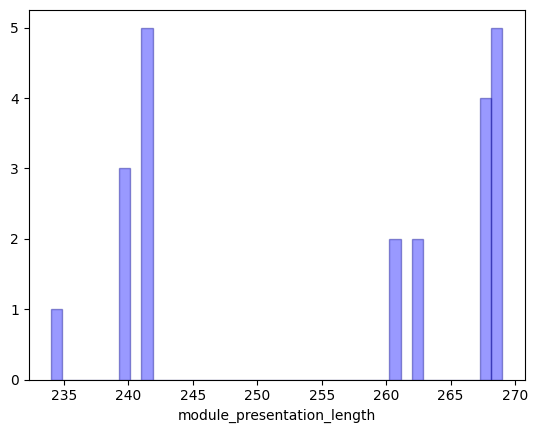

In [44]:
sns.distplot(courses['module_presentation_length'], hist=True, kde=False, 
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'darkblue'})

# Подготовка общего датасета

In [45]:
df1 = pd.DataFrame()

In [46]:
df1 = pd.merge(
    Train_Who,
    studentInfo,
    how="left",
    on=['id_student', 'code_module', 'code_presentation'],
)
df1.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N


In [47]:
df2 = pd.merge(
    df1,
    studentRegistration,
    how="left",
    on=['id_student', 'code_module', 'code_presentation'],
)
df2.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,-36.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,-32.0


In [48]:
df3 = pd.merge(
    df2,
    agg_ass_all2,
    how="left",
    on=['code_module', 'code_presentation'],
)
df3.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,-36.0,20.0,28.571429,200.0,116.0,123.857143,867.0,7
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,-32.0,20.0,28.571429,200.0,123.0,131.714286,922.0,7


In [49]:
df4 = pd.merge(
    df3,
    st_ass_all,
    how="left",
    on=['id_student'],
)
df4.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,date_registration,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,-36.0,20.0,28.571429,200.0,116.0,123.857143,867.0,7,0.0,7.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,-32.0,20.0,28.571429,200.0,123.0,131.714286,922.0,7,0.0,3.0


In [50]:
df5 = pd.merge(
    df4,
    st_weight,
    how="left",
    on=['code_module', 'code_presentation','id_student'],
)
df5.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked,total_stud_weight
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,20.0,28.571429,200.0,116.0,123.857143,867.0,7,0.0,7.0,200.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,20.0,28.571429,200.0,123.0,131.714286,922.0,7,0.0,3.0,40.0


In [51]:
df5['total_stud_weight_%'] = df5['total_stud_weight']/df5['total_weight_pres']
df5.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked,total_stud_weight,total_stud_weight_%
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,28.571429,200.0,116.0,123.857143,867.0,7,0.0,7.0,200.0,1.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,28.571429,200.0,123.0,131.714286,922.0,7,0.0,3.0,40.0,0.2


In [52]:
df6 = pd.merge(
    df5,
    diff_dates,
    how="left",
    on=['code_module', 'code_presentation','id_student'],
)
df6.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked,total_stud_weight,total_stud_weight_%,median_diff_date,mean_diff_date,sum_diff_date
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,123.857143,867.0,7,0.0,7.0,200.0,1.0,1.0,0.571429,4.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,131.714286,922.0,7,0.0,3.0,40.0,0.2,0.0,0.000000,0.0


In [53]:
df7 = pd.merge(
    df6,
    studentVle2,
    how="left",
    on=['code_module', 'code_presentation','id_student'],
)
df7.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,total_stud_weight_%,median_diff_date,mean_diff_date,sum_diff_date,median_date,mean_date,sum_date,median_click,mean_click,sum_click_by_site
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,1.0,1.0,0.571429,4.0,110.194958,110.194958,65566.0,2.847059,2.847059,1694.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,0.2,0.0,0.000000,0.0,29.574924,29.574924,9671.0,2.116208,2.116208,692.0


In [54]:
df8 = pd.merge(
    df7,
    vle_count,
    how="left",
    on=['code_module', 'code_presentation'],
)
df8.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,median_diff_date,mean_diff_date,sum_diff_date,median_date,mean_date,sum_date,median_click,mean_click,sum_click_by_site,activity_type
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,1.0,0.571429,4.0,110.194958,110.194958,65566.0,2.847059,2.847059,1694.0,453
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,0.0,0.000000,0.0,29.574924,29.574924,9671.0,2.116208,2.116208,692.0,462


In [55]:
df9 = pd.merge(
    df8,
    courses,
    how="left",
    on=['code_module', 'code_presentation'],
)
df9.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_diff_date,sum_diff_date,median_date,mean_date,sum_date,median_click,mean_click,sum_click_by_site,activity_type,module_presentation_length
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,0.571429,4.0,110.194958,110.194958,65566.0,2.847059,2.847059,1694.0,453,241
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,0.000000,0.0,29.574924,29.574924,9671.0,2.116208,2.116208,692.0,462,261


In [56]:
df10 = pd.merge(
    df9,
    a_pivot,
    how="left",
    on=['code_module', 'code_presentation'],
)
df10.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_date,sum_date,median_click,mean_click,sum_click_by_site,activity_type,module_presentation_length,CMA_count,Exam_count,TMA_count
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,110.194958,65566.0,2.847059,2.847059,1694.0,453,241,NaN,1.0,6.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,29.574924,9671.0,2.116208,2.116208,692.0,462,261,NaN,1.0,6.0


# Обработка датасета для построения модели

In [57]:
df10.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_date,sum_date,median_click,mean_click,sum_click_by_site,activity_type,module_presentation_length,CMA_count,Exam_count,TMA_count
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,...,110.194958,65566.0,2.847059,2.847059,1694.0,453,241,NaN,1.0,6.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,...,29.574924,9671.0,2.116208,2.116208,692.0,462,261,NaN,1.0,6.0


In [58]:
df10.columns

Index(['ID', 'id_student', 'code_module', 'code_presentation', 'gender',
       'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'date_registration', 'median_weight_pres', 'mean_weight_pres',
       'total_weight_pres', 'median_date_pres', 'mean_date_pres',
       'total_date_pres', 'id_assessment_count', 'is_banked_sum', 'is_banked',
       'total_stud_weight', 'total_stud_weight_%', 'median_diff_date',
       'mean_diff_date', 'sum_diff_date', 'median_date', 'mean_date',
       'sum_date', 'median_click', 'mean_click', 'sum_click_by_site',
       'activity_type', 'module_presentation_length', 'CMA_count',
       'Exam_count', 'TMA_count'],
      dtype='object')

In [59]:
cat_columns = ['code_module'
               , 'gender'
               , 'region'
               , 'highest_education'
               , 'imd_band'
               , 'age_band'
               , 'disability'

               
              ] 
num_columns = ['num_of_prev_attempts'
               , 'studied_credits'
               , 'date_registration'
               , 'median_weight_pres'
#                , 'mean_weight_pres'
               
               , 'median_date_pres'
#                , 'mean_date_pres'
               , 'total_date_pres'
               , 'is_banked_sum'
               , 'is_banked'
               , 'total_stud_weight'
               , 'total_stud_weight_%'
               , 'median_diff_date'
               , 'mean_diff_date'
               , 'sum_diff_date'
#                , 'median_date'
               , 'mean_date'
               , 'sum_date'
               , 'median_click'
               , 'mean_click'
#                , 'sum_click_by_site'
               , 'activity_type'
               , 'module_presentation_length'
               , 'id_assessment_count'
               , 'total_weight_pres'
               , 'CMA_count'
               , 'Exam_count'
               , 'TMA_count'
              ]

cols = cat_columns+num_columns

In [60]:
df10.shape

(26074, 38)

Заполнение пропусков

In [61]:
cat_features = df10[cat_columns].fillna('0')
num_features= df10[num_columns].fillna(0)

Применим one-hot-encoding к категориальным данным

In [62]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False).fit(cat_features)
train_cat_encoded = enc.transform(cat_features)

Применим MinMaxScaler к числовым признакам

In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(num_features)

In [64]:
X = np.concatenate((train_num_scaled, train_cat_encoded), axis=1)
y = Train_Target_reg['weighted_score']
features_names = np.append(num_columns, enc.get_feature_names_out(cat_columns))

Разбиение датасета на тренировочную и тестовую(валидационную) выборки

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Проверка и отбор фичей на значимость по модели RandomForestRegressor

In [67]:
forest = RandomForestRegressor(n_estimators=600, max_depth=6, random_state=42)

In [68]:
%%time
forest.fit(X_train, y_train)

CPU times: total: 1min 6s
Wall time: 1min 6s


RandomForestRegressor(max_depth=6, n_estimators=600, random_state=42)

In [69]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [70]:
print('mse', mse(y_train, y_train_pred))

mse 267.49848606561534


In [71]:
# mse 276.16526893001253
# mse 290.44377600502827
# mse 291.3724056745651
# mse 269.7134417485688
# mse 269.346440910898
# mse 269.3443353010348
# mse 269.3419168038392
# mse 269.1490202102002
# mse 267.65415508113057
# mse 267.6502868034782
# mse 267.5002596318716

In [72]:
print('mse', mse(y_test, y_test_pred))

mse 275.8420892256743


In [73]:
# mse 284.0089398671498
# mse 296.82254205287626
# mse 297.36329680851065
# mse 277.6256301657911
# mse 277.5614944570717
# mse 277.5549118889368
# mse 277.4142303156172
# mse 275.9850346804189
# mse 275.84222232347014

## Подбор наилучших гиперпараметорв модели

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
parameters = {'max_features': [4, 7, 10, 13]
              , 'min_samples_leaf': [1, 3, 5, 7, 9]
              , 'max_depth': [5,10,15,20]}

In [76]:
greed_search = GridSearchCV(forest,param_grid=parameters,cv=4
                            , scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1
                            , verbose = 1, return_train_score=True)

In [77]:
%%time
model_greed_search = greed_search.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
CPU times: total: 45 s
Wall time: 23min 11s


In [78]:
print(f'Лучшие параметры: {model_greed_search.best_params_}')
print(f'Best score is: {model_greed_search.best_score_}')

Лучшие параметры: {'max_depth': 15, 'max_features': 13, 'min_samples_leaf': 1}
Best score is: -265.08625427882447


In [79]:
y_train_pred = model_greed_search.predict(X_train)
y_test_pred = model_greed_search.predict(X_test)

In [80]:
print('mse', mse(y_train, y_train_pred))

mse 154.25356308634176


In [81]:
mse 173.1915249292899
mse 170.95137321711576
mse 172.29270114670047
mse 181.3236324737023
mse 173.06026649565342
mse 168.08384119814986
mse 158.58302356393975

SyntaxError: invalid syntax (1344953293.py, line 1)

In [82]:
print('mse', mse(y_test, y_test_pred))

mse 264.45264744072887


In [83]:
mse 274.8788040045249
mse 272.4689655209275
mse 272.53771433718293
mse 272.0147002232825
mse 280.47729435836425
mse 267.3032782687816
mse 266.74837647794266

SyntaxError: invalid syntax (2334589749.py, line 1)

## Обучение модели на полной выборке

In [84]:
model_greed_search = greed_search.fit(X, y)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


# Тестовая выборка

In [85]:
df_test = pd.DataFrame()

In [86]:
df_test1 = pd.merge(
    Test_Who,
    studentInfo,
    how="left",
    on=['id_student', 'code_module', 'code_presentation'],
)
df_test1.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,90,N


In [87]:
df_test2 = pd.merge(
    df_test1,
    studentRegistration,
    how="left",
    on=['id_student', 'code_module', 'code_presentation'],
)
df_test2.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,-92.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,90,N,-109.0


In [88]:
df_test3 = pd.merge(
    df_test2,
    agg_ass_all2,
    how="left",
    on=['code_module', 'code_presentation'],
)
df_test3.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,-92.0,25.0,28.571429,200.0,86.5,95.833333,575.0,7
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,90,N,-109.0,15.5,30.000000,300.0,119.5,114.250000,914.0,10


In [89]:
df_test4 = pd.merge(
    df_test3,
    st_ass_all,
    how="left",
    on=['id_student'],
)
df_test4.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,date_registration,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,-92.0,25.0,28.571429,200.0,86.5,95.833333,575.0,7,3.0,9.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,-109.0,15.5,30.000000,300.0,119.5,114.250000,914.0,10,NaN,NaN


In [90]:
df_test5 = pd.merge(
    df_test4,
    st_weight,
    how="left",
    on=['code_module', 'code_presentation','id_student'],
)
df_test5.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,median_weight_pres,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked,total_stud_weight
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,25.0,28.571429,200.0,86.5,95.833333,575.0,7,3.0,9.0,200.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,15.5,30.000000,300.0,119.5,114.250000,914.0,10,NaN,NaN,NaN


In [91]:
df_test5['total_stud_weight_%'] = df_test5['total_stud_weight']/df_test5['total_weight_pres']
df_test5.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_weight_pres,total_weight_pres,median_date_pres,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked,total_stud_weight,total_stud_weight_%
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,28.571429,200.0,86.5,95.833333,575.0,7,3.0,9.0,200.0,1.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,30.000000,300.0,119.5,114.250000,914.0,10,NaN,NaN,NaN,NaN


In [92]:
df_test6 = pd.merge(
    df_test5,
    diff_dates,
    how="left",
    on=['code_module', 'code_presentation','id_student'],
)
df_test6.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_date_pres,total_date_pres,id_assessment_count,is_banked_sum,is_banked,total_stud_weight,total_stud_weight_%,median_diff_date,mean_diff_date,sum_diff_date
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,95.833333,575.0,7,3.0,9.0,200.0,1.0,10.0,20.333333,122.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,114.250000,914.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df_test7 = pd.merge(
    df_test6,
    studentVle2,
    how="left",
    on=['code_module', 'code_presentation','id_student'],
)
df_test7.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,total_stud_weight_%,median_diff_date,mean_diff_date,sum_diff_date,median_date,mean_date,sum_date,median_click,mean_click,sum_click_by_site
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,1.0,10.0,20.333333,122.0,139.425532,139.425532,6553.0,6.319149,6.319149,297.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df_test8 = pd.merge(
    df_test7,
    vle_count,
    how="left",
    on=['code_module', 'code_presentation'],
)
df_test8.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,median_diff_date,mean_diff_date,sum_diff_date,median_date,mean_date,sum_date,median_click,mean_click,sum_click_by_site,activity_type
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,10.0,20.333333,122.0,139.425532,139.425532,6553.0,6.319149,6.319149,297.0,365
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196


In [95]:
df_test9 = pd.merge(
    df_test8,
    courses,
    how="left",
    on=['code_module', 'code_presentation'],
)
df_test9.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_diff_date,sum_diff_date,median_date,mean_date,sum_date,median_click,mean_click,sum_click_by_site,activity_type,module_presentation_length
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,20.333333,122.0,139.425532,139.425532,6553.0,6.319149,6.319149,297.0,365,262
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196,241


In [96]:
df_test10 = pd.merge(
    df_test9,
    a_pivot,
    how="left",
    on=['code_module', 'code_presentation'],
)
df_test10.head(2)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,...,mean_date,sum_date,median_click,mean_click,sum_click_by_site,activity_type,module_presentation_length,CMA_count,Exam_count,TMA_count
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,...,139.425532,6553.0,6.319149,6.319149,297.0,365,262,NaN,1.0,6.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,...,NaN,NaN,NaN,NaN,NaN,196,241,4.0,2.0,4.0


In [97]:
cat_features = df_test10[cat_columns].fillna('0')
num_features= df_test10[num_columns].fillna(0)

In [98]:
test_cat_encoded = enc.transform(cat_features)

In [99]:
test_num_scaled = scaler.transform(num_features)

In [100]:
X_test = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)
features_names = np.append(num_columns, enc.get_feature_names_out(cat_columns))

In [101]:
y_predict = model_greed_search.predict(X_test)

In [102]:
y_predict

array([55.89683915, 52.52994226, 54.519184  , ..., 71.54624704,
       80.02785149, 56.12134916])

In [103]:
Submission_reg = pd.read_csv('Submission_reg.csv')

In [104]:
Submission_reg['weighted_score'] = y_predict

In [105]:
Submission_reg

,ID,weighted_score
0,26074,55.896839
1,26075,52.529942
2,26076,54.519184
3,26077,0.584203
4,26078,55.617530
...,...,...
6514,32588,6.292733
6515,32589,4.490546
6516,32590,71.546247
6517,32591,80.027851


Сохраним полученный результат:

In [106]:
Submission_reg.to_csv('UrFU_AI_Eng_2022_Clf_06062023_final.csv', index=False)

**Основные выводы:**

- потраченное чистое время: ~ 4 дня

- результат - неудовлетворителен относителя заявленных нормативов

- некоторые (зачертнуто), ОГРОМНЫЕ сомнения в том, что реально добиться метрики менее 200 на лидерборде, точнее <200 еще возможно, <100 анриал

- дальнейшие выводы - смысла убиваться, перебирать все таблицы и метрики нет, в прошлом семестре был дух совервнования, в этом на классификации тоже, а тут нет от слова совсем

*Дорогой дневничок: выговорился. хоть полегчало*

### Подтверждение результата лидерборда:

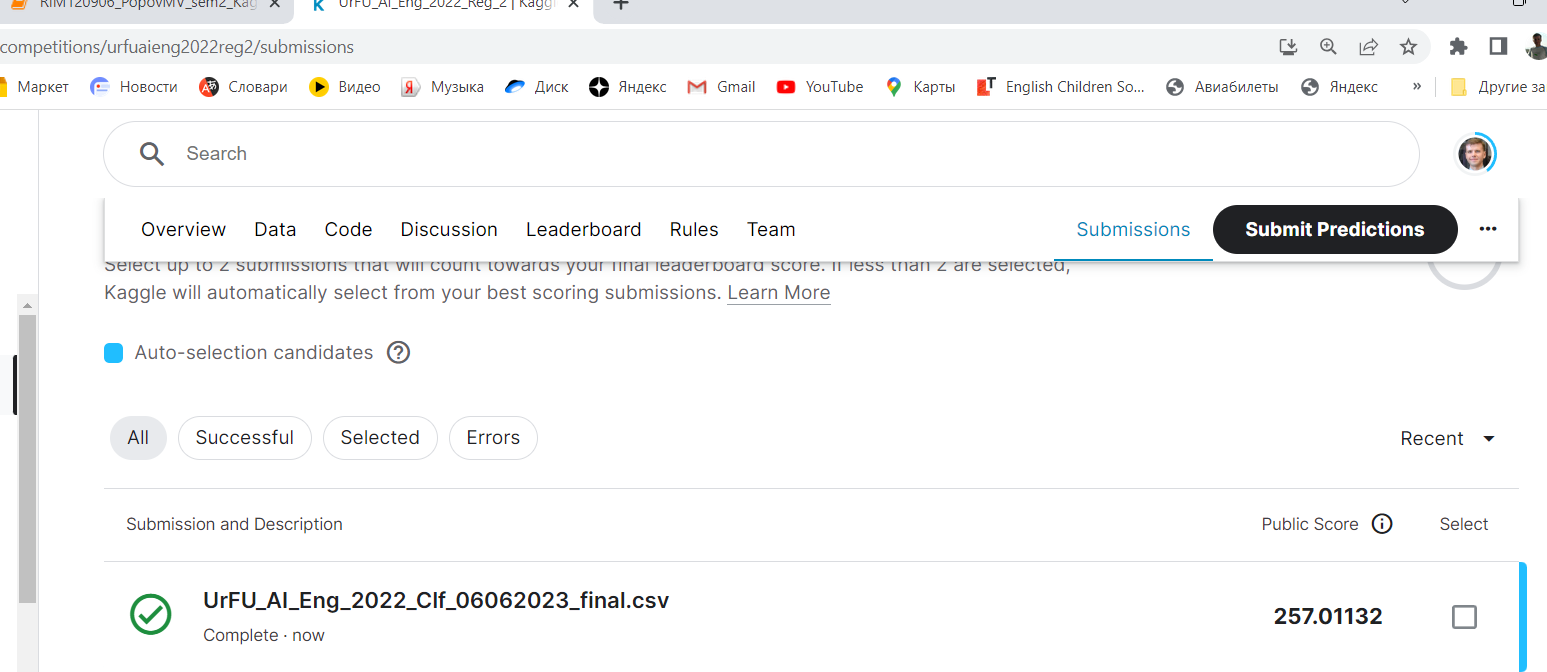

In [107]:
Image("reg2_1.png", width=620, height=480) 

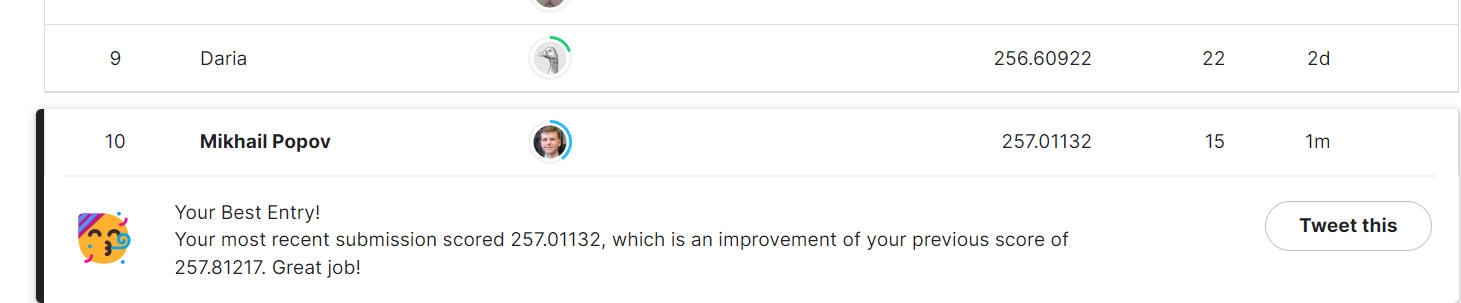

In [108]:
Image("reg2_2.png", width=620, height=480) 